<hr style="border:2px solid black"> </hr>

<div class="alert alert-success">

<b> In this notebook, we investigate the fuel poverty across the UK mainland, at local authority or government region levels..</b>
</div>

In [1712]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import seaborn as sns
import copy
from copy import deepcopy
import geopandas as gpd

from matplotlib import rcParams

# Set up the aesthetics for the plot
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

def weighted_median(data, weights):
    sort_idx = np.argsort(data)
    data = data[sort_idx]
    weights = weights[sort_idx]
    cumsum = np.cumsum(weights)
    cutoff = np.sum(weights) / 2.0
    median = data[cumsum >= cutoff][0]

    return median

def weighted_mean(data, weights):
    mean = np.sum(data * weights) / np.sum(weights)
    return mean

root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data')

# Scotland

Step one, load the SHCS dataset.
The reqiured data include:
1. Energy Cost: annkWh_fp3_BRE
2. Unequivalised household AHC income: incAHC
3. Fuel type: primFuel_biomass
4. Geo location: la
5. **Be careful of the sampling weights** For estimating the fuel poverty, we should use "fpWghtAHC" for the overall scotland over year 2019, and use "lafpWghtAHC" for combining three-year data for LA-level analysis

In [1713]:
data_folder_path_SHCS = os.path.join(root_path, "SHCS-2019", "spss", "spss25")
## arc_P75std_whd is their calculated fuel cost
SHCS_subset = ["annkWh_fp3_BRE", "incAHC", "primFuel_biomass", "la", "fpWghtAHC", "lafpWghtAHC", "L3", "arc_P75std_whd", "FP3mis9010_rrrstidis", "hhtype_mis", "efficiency_PCA"]
df_SHCS = pd.read_spss(os.path.join(data_folder_path_SHCS, "shcs2019_dataset.sav"))[SHCS_subset]

def preprocess_df(df):
    ## process str liuke ">=xx or <= xx", extract the number xx from them
    df = df.assign(annkWh_fp3_BRE = df["annkWh_fp3_BRE"].astype("str").str.extract('(\d+)').astype("float"),
                             incAHC = df["incAHC"].astype("str").str.extract('(\d+)').astype("float"),
                   arc_P75std_whd = df["arc_P75std_whd"].astype("str").str.extract('(\d+)').astype("float"))

    # drop household with no income data
    df = df.dropna(subset = ["incAHC"])
    return df

df_SHCS = preprocess_df(df_SHCS)
df_SHCS

,annkWh_fp3_BRE,incAHC,primFuel_biomass,la,fpWghtAHC,lafpWghtAHC,L3,arc_P75std_whd,FP3mis9010_rrrstidis,hhtype_mis,efficiency_PCA
0,11205.0,24696.0,Mains gas,"Edinburgh, City of",1297.04,432.35,Single,891.0,Not Fuel Poor,single,89.6
1,26797.0,10824.0,Mains gas,North Ayrshire,1045.32,348.44,Single,1452.0,Not Fuel Poor,single,90.0
2,20170.0,43108.0,Mains gas,East Ayrshire,920.04,306.68,Single,1423.0,Not Fuel Poor,couple,89.7
3,15235.0,13610.0,Mains gas,North Lanarkshire,1811.35,603.78,Single,992.0,Not Fuel Poor,pensioner single,90.0
4,21361.0,4882.0,Mains gas,Perth and Kinross,747.14,249.05,Single,1242.0,Fuel Poor,pensioner single,90.0
...,...,...,...,...,...,...,...,...,...,...,...
2991,68025.0,12266.0,Biomass,Dumfries and Galloway,688.27,229.42,Single,3891.0,Fuel Poor,single,32.0
2993,16798.0,5424.0,Mains gas,Fife,1278.45,426.15,Single,1063.0,Fuel Poor,single,84.0
2994,25510.0,26890.0,Mains gas,Stirling,528.71,176.24,Single,2024.0,Not Fuel Poor,cpl+3,90.0
2995,25708.0,11096.0,Mains gas,West Lothian,723.70,241.23,Single,1575.0,Fuel Poor,pensioner couple,66.0


In [1714]:
# the minimum sample size for each local authority (LA)
df_SHCS.groupby("la").size().min()

54

In [1715]:
# the proportion of heating fuel. Note we need to take into account the sample weight
df_SHCS[df_SHCS["primFuel_biomass"] == "Oil"]["fpWghtAHC"].sum() / df_SHCS['fpWghtAHC'].sum()

0.052020970871187684

In [1716]:
# the options of heating fuels
df_SHCS["primFuel_biomass"].unique()

['Mains gas', 'Electricity', 'Oil', 'Communal Heating', 'Solid mineral fuel', 'LPG bulk or bottled', 'Biomass']
Categories (7, object): ['Biomass', 'Communal Heating', 'Electricity', 'LPG bulk or bottled', 'Mains gas', 'Oil', 'Solid mineral fuel']

We see if we only use the 10% definition, the fp rate will be 10% higher than published result even under their modelled costs.

In [1717]:
a = df_SHCS["incAHC"] * 0.1 <= df_SHCS["arc_P75std_whd"]
fp_res = np.sum(a.values * df_SHCS["fpWghtAHC"].values) / np.sum(df_SHCS["fpWghtAHC"].values) * 100
print(f"The estimated fp res in 2019 is {fp_res}%")
print("The estimated fuel poverty based on their cost data and the 10% def only is indeed higher than the published SHCS 2019 result (24.6%)")

The estimated fp res in 2019 is 36.05745265546962%
The estimated fuel poverty based on their cost data and the 10% def only is indeed higher than the published SHCS 2019 result (24.6%)


Next is to find the fuel price for each of the heating fuel. Our data source is [nottenergy](https://nottenergy.com/resources/energy-cost-comparison/5/) and the BEIS
Biomass is the average of wood Pellets and seasoned wood
Communal heating seems can be cheaper than gas, so we set the price to be the gas price
Oil is Kerosene as it's mainly used at residential homes based on [here](https://www.crownoil.co.uk/guides/heating-oil-guide/#whatisheatingoil).
Solid mineral fuel is the coal.
Electricity is assumed to be Storage heater and is 90% E7 low + 10% E7 high.

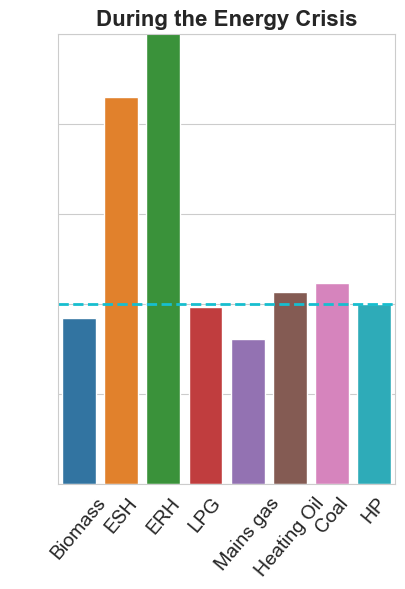

When the interest rate is 3%, the HP unit cost is £0.10901474193427085
When the interest rate is 4%, the HP unit cost is £0.10984995242906918
When the interest rate is 5%, the HP unit cost is £0.1107272954439866
When the interest rate is 6%, the HP unit cost is £0.11164529512779052
When the interest rate is 7%, the HP unit cost is £0.11260215215500563


{'Biomass': 0.0921764705882353,
 'Communal Heating': 0.08066666666666666,
 'Electricity_store': 0.215,
 'Electricity_pure': 0.3,
 'LPG bulk or bottled': 0.09833333333333333,
 'Mains gas': 0.08066666666666666,
 'Oil': 0.10666666666666666,
 'Solid mineral fuel': 0.11133333333333333,
 'Wood': 0.08952941176470589,
 'Electricity': 0.26136363636363635,
 'HP': 0.1}

In [1718]:
fuel_price_dict_2021 = {
    "Biomass": (6.12 + 5.8) / 2,
    "Communal Heating": 3.42,
    "Electricity_store": 12.1,
    "Electricity_pure": 19.00,
    "LPG bulk or bottled": 8.09,
    "Mains gas": 3.42,
    "Oil": 5.24,
    "Solid mineral fuel": 6.2,
    "Wood": 5.8,
}

fuel_price_dict_2019 = {
    "Biomass": 5.585,
    "Communal Heating": 3.78,
    "Electricity_store": 11,
    "Electricity_pure": 17,
    "LPG bulk or bottled": 6.31,
    "Mains gas": 3.78,
    "Oil": 5.4,
    "Solid mineral fuel": 5.66,
    "Wood": 5.26,
}

fuel_price_dict_2022 = {
    "Biomass": (7.61+8.06) / 2,
    "Communal Heating": 7.26,
    "Electricity_store": 21.5,
    "Electricity_pure": 30.00,
    "LPG bulk or bottled": 8.85,
    "Mains gas": 7.26,
    "Oil": 9.6,
    "Solid mineral fuel": 8.35,
    "Wood": 7.61,
}


fuel_price_dict = {2019: fuel_price_dict_2019,
                   2021: fuel_price_dict_2021,
                   2022: fuel_price_dict_2022}

### "Electricity" is a weighted average of the ESH and ERH
years = list(fuel_price_dict.keys())
for year in years:
    fuel_price_dict[year]['Electricity'] = (5/11) * fuel_price_dict[year]["Electricity_store"] + (6/11)*fuel_price_dict[year]["Electricity_pure"]


HP_SPF = 3

fuel_eff_dict = {
    "Biomass": .85,
    "Communal Heating": .9,
    "Electricity_store": 1,
    "Electricity_pure": 1,
    "Electricity": 1,
    "LPG bulk or bottled": .9,
    "Mains gas": .9,
    "Oil": .9,
    "Solid mineral fuel": .75,
    "HP": HP_SPF,
    "Wood": 0.85,
}

price_year = 2022

consider_upfrontcost = True # if this is True, then we will consider the upfront cost into the energy cost of HPs.
interest_rate = 7
gov_policy = True # if this is True, then we will consider the £5000 England Gov support towards HP upfront.
ave_num_years = 14.56 # the number of years the DNO to spread out the network upgrade cost

HP_life_exp = 20 # HP's life expectency
# below is the average additional cost per year to consider the HP upfront cost and mortage interest rate
# you can get the same result by the Net Present Value (NPV) calculation, note that the interest rate needs to be divided by 12
# for monthly interest rate, and the first month will BE discounted.
# e.g., 3350 / np.sum([1 / (1+0.03/12)**i for i in range(1,20*12+1)]) * 20*12
HP_upfront_cost_dict = {3:11114.14 / HP_life_exp,
                        4:12143.85 / HP_life_exp,
                        5:13225.51 / HP_life_exp,
                        6:14357.28 / HP_life_exp,
                        7:15536.99 / HP_life_exp}

if gov_policy:
    HP_upfront_cost_dict = {3:4458.96 / HP_life_exp,
                        4:4872.08 / HP_life_exp,
                        5:5306.04 / HP_life_exp,
                        6:5760.11 / HP_life_exp,
                        7:6233.4 / HP_life_exp}

title_dict = {2019: 'Pre-crisis Period',
              2022: 'During the Energy Crisis'}

mean_annual_kWh = 28427 * 0.87

Scot_fuel_uni_cost_dict = {}
for key in fuel_price_dict[price_year].keys():
    Scot_fuel_uni_cost_dict[key] = fuel_price_dict[price_year][key] / fuel_eff_dict[key] / 100

Scot_fuel_uni_cost_dict["HP"] = fuel_price_dict[price_year]["Electricity_pure"] / fuel_eff_dict["HP"] / 100

# Define the colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
hp_color = '#17becf'

# Update the color list with the HP color
colors_with_hp = colors.copy() + [hp_color]
# colors_with_hp.insert(-1, hp_color)

keys = list(Scot_fuel_uni_cost_dict.keys())
keys.remove('Communal Heating')
# keys.remove('Electricity_pure')
keys.remove('Wood')
keys.remove('Electricity')

# Get values in the same order as keys, and parse percentage values
vals = [Scot_fuel_uni_cost_dict[k] for k in keys]

plt.figure(figsize=[4.5, 6])
sns.barplot(x=keys, y=vals, palette=colors_with_hp)
plt.axhline(Scot_fuel_uni_cost_dict["HP"], color=hp_color, linestyle='--', linewidth=2)

plt.xticks(rotation=50)
plt.ylabel("£/kWh", fontdict={'size':14})
plt.xticks(range(len(keys)), ['Biomass', 'ESH', 'ERH', 'LPG', 'Mains gas', 'Heating Oil', 'Coal', "HP"])
plt.ylim([0, 0.25])
plt.title(f"{title_dict[price_year]}", fontsize=16, fontweight='bold')

if price_year == 2022:
    plt.yticks(color='w')
    plt.ylabel("")

plt.subplots_adjust(left=0.2,
                    bottom=0.18,
                    right=0.95,
                    top=0.93,
                    wspace=0.05,
                    hspace=0.05)

plt.savefig(os.path.join(os.getcwd(), "figures", f"unitprice_{price_year}_SPF{HP_SPF}.pdf"), dpi=300)
plt.show()

if consider_upfrontcost:
    for rate in HP_upfront_cost_dict.keys():
        print(f"When the interest rate is {rate}%, the HP unit cost is £{Scot_fuel_uni_cost_dict['HP'] + HP_upfront_cost_dict[rate] / mean_annual_kWh}")

Scot_fuel_uni_cost_dict

In [1719]:
# load the network upgrade cost df averaged to each household
df_network_upgrade_cost = pd.read_csv(os.path.join(root_path, "UKM_PrimarySubstation_Data", "reg_upgrade_cost.csv"))
reg2networkcost_dict = {}
for i, subdf in df_network_upgrade_cost.iterrows():
    reg = subdf["RegName"]
    if reg == 'city of edinburgh':
        reg = 'edinburgh, city of'
    if reg == 'east of england':
        reg = 'east'
    reg2networkcost_dict[reg] = subdf['Upgrade Cost per Household (£)']
    
reg2networkcost_dict

{'north east': 0.0,
 'north west': 13.407681985111443,
 'yorkshire and the humber': 13.906407962927924,
 'east midlands': 26.665770379729143,
 'west midlands': 20.352788378667636,
 'east': 113.939946480995,
 'london': 0.4636384908525128,
 'south east': 11.607751599908074,
 'south west': 33.85285611382119,
 'clackmannanshire': 0.0,
 'dumfries and galloway': 74.66811322810803,
 'east ayrshire': 0.0,
 'east lothian': 0.0,
 'east renfrewshire': 0.0,
 'na h-eileanan siar': 739.3756403224768,
 'falkirk': 0.0,
 'highland': 140.39457074980842,
 'inverclyde': 0.0,
 'midlothian': 0.0,
 'moray': 194.50787392870367,
 'north ayrshire': 0.0,
 'orkney islands': 25.2475151227181,
 'scottish borders': 99.84642082870413,
 'shetland islands': 241.1460439708132,
 'south ayrshire': 53.347520886915206,
 'south lanarkshire': 9.093708456916652,
 'stirling': 13.124426638433778,
 'aberdeen city': 0.0,
 'aberdeenshire': 418.6419866576468,
 'argyll and bute': 121.967512311782,
 'edinburgh, city of': 26.3128566829

Calculate the energy cost per household and judge fuel poverty
Based on SHCS, on average 87% energy is used for heating, and the remaining tis used for lighting (10%) and cooking (3%), so we assume the 13% energy of all the household are costed at the standard electricity tariff.

In [1720]:
def fp_estimation(df, fuel_uni_cost_dict, weight_key, la_analysis = False, ave_cost = False, consider_network_upgrade = False):
    # calculate energy cost per household
    df["energy_cost"] =  df["annkWh_fp3_BRE"] * df["primFuel_biomass"].map(fuel_uni_cost_dict)* 0.87 + 0.13 * df["annkWh_fp3_BRE"] * fuel_uni_cost_dict['Electricity_pure']
    # (1-0.5*(df["L3"] == "Dual")
    if consider_upfrontcost:
        df["energy_cost"] = df["energy_cost"] + (df["primFuel_biomass"] == "HP").values.astype("float") * HP_upfront_cost_dict[interest_rate]
        
    if consider_network_upgrade:
        df["energy_cost"] = df["energy_cost"] + df["la"].str.lower().map(reg2networkcost_dict) / ave_num_years

    # estimate if it is fuel poor
    df["is_fp"] = df["incAHC"] * 0.1 <= df["energy_cost"]
    if not la_analysis:
        # estimate the rate
        fp_rate = np.sum(df["is_fp"].values * df[weight_key].values) / np.sum(df[weight_key].values)

        return fp_rate * 100

    res_dict = {}
    for la in df['la'].unique():
        df_sub = df[df['la'] == la]
        fp_rate = np.sum(df_sub["is_fp"].values * df_sub[weight_key].values) / np.sum(df_sub[weight_key].values)

        res_dict[la] = fp_rate * 100
    return res_dict

Scot_fp_res = fp_estimation(df=df_SHCS, fuel_uni_cost_dict = Scot_fuel_uni_cost_dict, weight_key='fpWghtAHC')
print(f"the estimated fuel poverty rate is {Scot_fp_res}%")

the estimated fuel poverty rate is 67.2617578881238%


If we replace all the nongas heating to HPs

In [1721]:
root_path

'C:\\Users\\Zhou_Ming\\Desktop\\Coding\\FuelPoverty\\FuelPoverty_data'

In [1722]:
map_dict = {"Biomass": "HP",
            "Communal Heating": "Communal Heating",
            "Electricity": "HP",
            "LPG bulk or bottled": "HP",
            "Mains gas": "Mains gas",
            "Oil": "HP",
            "Solid mineral fuel": "HP",}

df_SHCS_replace = df_SHCS.copy()
df_SHCS_replace['primFuel_biomass'] = df_SHCS_replace['primFuel_biomass'].map(map_dict)
Scot_fp_res_HP = fp_estimation(df=df_SHCS_replace, fuel_uni_cost_dict = Scot_fuel_uni_cost_dict, weight_key='fpWghtAHC', consider_network_upgrade = True)
print(f"the estimated fuel poverty rate AFTER HP replace is {Scot_fp_res_HP}%")

the estimated fuel poverty rate AFTER HP replace is 65.1622709683117%


In the next step, we analyse the LA-level fp result;
To do so, we need to load the three-year fp statistics from 2017-2019

In [1723]:
df_SHCS_3y = []
for year in [2017, 2018, 2019]:
    data_folder_path_SHCS = os.path.join(root_path, "SHCS-2019", "spss", "spss25")
    # load and preprocess
    df_SHCS_3y.append(preprocess_df(pd.read_spss(os.path.join(data_folder_path_SHCS, f"shcs{year}_dataset.sav"))[SHCS_subset]))

df_SHCS_3y = pd.concat(df_SHCS_3y)
df_SHCS_3y.head()

,annkWh_fp3_BRE,incAHC,primFuel_biomass,la,fpWghtAHC,lafpWghtAHC,L3,arc_P75std_whd,FP3mis9010_rrrstidis,hhtype_mis,efficiency_PCA
0,51087.0,19817.0,Mains gas,Midlothian,425.25,141.75,Single,2238.0,Not Fuel Poor,pensioner single,90.3
1,14203.0,13989.0,Mains gas,South Lanarkshire,1181.44,393.81,Single,1071.0,Not Fuel Poor,pensioner couple,86.9
2,10804.0,12030.0,Mains gas,"Edinburgh, City of",1358.08,452.69,Single,767.0,Not Fuel Poor,single,90.0
3,17779.0,5984.0,Mains gas,Fife,1050.23,350.08,Single,1102.0,Fuel Poor,couple,87.3
4,23867.0,26332.0,Mains gas,Glasgow City,1625.21,541.74,Single,1369.0,Not Fuel Poor,lone parent+1,90.0


In [1724]:
# remove N/A
df_SHCS_3y = df_SHCS_3y[df_SHCS_3y["primFuel_biomass"] != 'N/A or Unobtainable']
df_SHCS_3y

,annkWh_fp3_BRE,incAHC,primFuel_biomass,la,fpWghtAHC,lafpWghtAHC,L3,arc_P75std_whd,FP3mis9010_rrrstidis,hhtype_mis,efficiency_PCA
0,51087.0,19817.0,Mains gas,Midlothian,425.25,141.75,Single,2238.0,Not Fuel Poor,pensioner single,90.3
1,14203.0,13989.0,Mains gas,South Lanarkshire,1181.44,393.81,Single,1071.0,Not Fuel Poor,pensioner couple,86.9
2,10804.0,12030.0,Mains gas,"Edinburgh, City of",1358.08,452.69,Single,767.0,Not Fuel Poor,single,90.0
3,17779.0,5984.0,Mains gas,Fife,1050.23,350.08,Single,1102.0,Fuel Poor,couple,87.3
4,23867.0,26332.0,Mains gas,Glasgow City,1625.21,541.74,Single,1369.0,Not Fuel Poor,lone parent+1,90.0
...,...,...,...,...,...,...,...,...,...,...,...
2991,68025.0,12266.0,Biomass,Dumfries and Galloway,688.27,229.42,Single,3891.0,Fuel Poor,single,32.0
2993,16798.0,5424.0,Mains gas,Fife,1278.45,426.15,Single,1063.0,Fuel Poor,single,84.0
2994,25510.0,26890.0,Mains gas,Stirling,528.71,176.24,Single,2024.0,Not Fuel Poor,cpl+3,90.0
2995,25708.0,11096.0,Mains gas,West Lothian,723.70,241.23,Single,1575.0,Fuel Poor,pensioner couple,66.0


In [1725]:
# some data exploreation
res = df_SHCS_3y[df_SHCS_3y["primFuel_biomass"] == "Mains gas"]["lafpWghtAHC"].sum() / df_SHCS_3y["lafpWghtAHC"].sum()
print(f"The Scottish Gas rate is {res}")

res = df_SHCS_3y[df_SHCS_3y["primFuel_biomass"] == "Electricity"]["lafpWghtAHC"].sum() / df_SHCS_3y["lafpWghtAHC"].sum()
print(f"The Scottish electric heater rate is {res}")

print(f"Scotland mean household energy consumption for heating is {weighted_mean(0.87*df_SHCS['annkWh_fp3_BRE'].values, df_SHCS['fpWghtAHC'])} kWh")

The Scottish Gas rate is 0.8011216482512541
The Scottish electric heater rate is 0.10702002113289738
Scotland mean household energy consumption for heating is 23613.471203792094 kWh


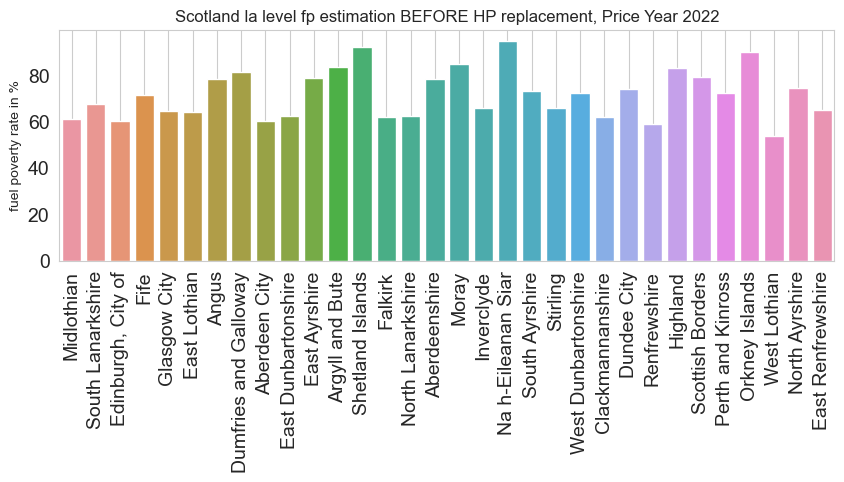

In [1726]:
# LA fuel poverty res
Scot_la_fp_estimation_dict = fp_estimation(df_SHCS_3y, Scot_fuel_uni_cost_dict, weight_key = "lafpWghtAHC", la_analysis = True)

keys = list(Scot_la_fp_estimation_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [Scot_la_fp_estimation_dict[k] for k in keys]
plt.figure(figsize=[10,3])
sns.barplot(x=keys, y=vals)
plt.xticks(rotation = 90)
plt.ylabel("fuel poverty rate in %")
plt.grid()
vmin, vmax = 0, 1.05 * np.max(vals)
plt.title(f"Scotland la level fp estimation BEFORE HP replacement, Price Year {price_year}")
plt.ylim([vmin, vmax])
plt.show()

if we replace nongas to HPs

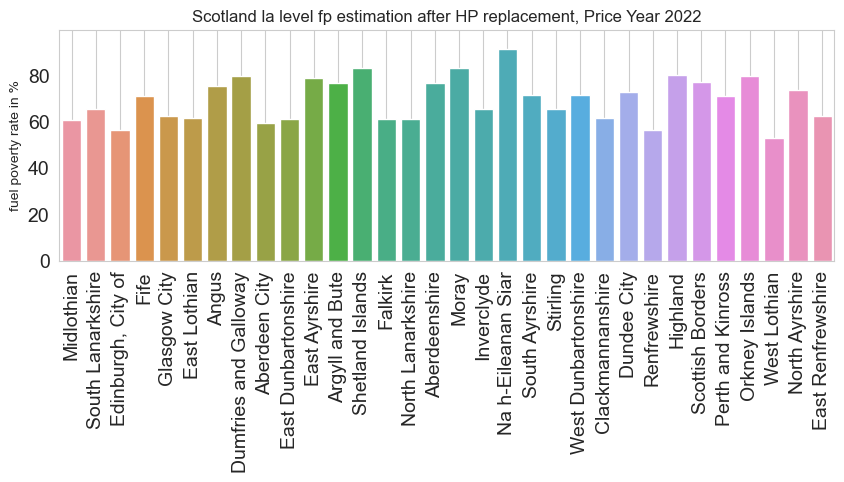

In [1727]:
df_SHCS_3y_replace = df_SHCS_3y.copy()
df_SHCS_3y_replace['primFuel_biomass'] = df_SHCS_3y_replace['primFuel_biomass'].map(map_dict)

Scot_la_fp_estimation_HP_dict = fp_estimation(df_SHCS_3y_replace, Scot_fuel_uni_cost_dict, weight_key = "lafpWghtAHC", la_analysis = True, consider_network_upgrade = True)

keys = list(Scot_la_fp_estimation_HP_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [Scot_la_fp_estimation_HP_dict[k] for k in keys]
plt.figure(figsize=[10,3])
sns.barplot(x=keys, y=vals)
plt.xticks(rotation = 90)
plt.ylabel("fuel poverty rate in %")
plt.grid()
plt.title(f"Scotland la level fp estimation after HP replacement, Price Year {price_year}")
plt.ylim([vmin, vmax])
plt.show()

Put them together for better comparison

In [1728]:
Scot_la_fp_estimation_HP_dict['Scottish Borders']

76.80557619942518

In [1729]:
Scot_la_fp_estimation_dict['Scottish Borders']

78.9793572749896

# England

In [1730]:
# load the dataframe
data_folder_path_EHS_FP = os.path.join(root_path, "EHS-FuelPoverty-2019", "spss", "spss25")
subset = ["WHDBroad", "fuelexpn", "wathcost", "spahcost", "litecost", "cookcost", "fpfullinc", "HousingCosts", "Mainfueltype", "gorehs", "aagph1819", "Ongas", "CentralHeating"]
df_EHS_FP = pd.read_spss(os.path.join(data_folder_path_EHS_FP, "fuel_poverty_data_2019_end_user_licence.sav"))[subset]

df_EHS_FP["incAHC"] = df_EHS_FP["fpfullinc"] - df_EHS_FP["HousingCosts"]
df_EHS_FP

,WHDBroad,fuelexpn,wathcost,spahcost,litecost,cookcost,fpfullinc,HousingCosts,Mainfueltype,gorehs,aagph1819,Ongas,CentralHeating,incAHC
0,Yes,1140.19,118.69,544.79,431.99,44.72,17387.0,0.0,gas,Yorkshire and the Humber,2957.0,Yes,central heating,17387.0
1,No,1635.19,114.30,812.53,666.80,41.56,57216.0,14400.0,gas,West Midlands,2701.0,Yes,central heating,42816.0
2,No,1808.14,263.34,846.29,630.36,68.15,78418.0,16200.0,other,South East,1327.0,No,central heating,62218.0
3,Yes,1439.17,59.19,748.54,589.00,42.44,10536.0,0.0,gas,South West,5350.0,Yes,central heating,10536.0
4,No,689.93,104.45,188.58,354.46,42.44,30507.0,3796.0,gas,South West,574.0,Yes,central heating,26711.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11969,No,896.76,154.10,240.69,450.93,51.04,31631.0,13560.0,gas,London,1213.0,Yes,central heating,18071.0
11970,No,1122.06,175.18,327.19,562.24,57.45,50031.0,12000.0,gas,London,886.0,Yes,central heating,38031.0
11971,No,897.84,77.76,414.14,368.39,37.55,21240.0,0.0,gas,Yorkshire and the Humber,2760.0,Yes,central heating,21240.0
11972,No,1729.26,80.49,626.14,965.85,56.78,24602.0,6600.0,gas,North East,4982.0,Yes,central heating,18002.0


In [1731]:
# minimum sample size
df_EHS_FP.groupby("gorehs").size().min()

729

As England data fuel type only has gas, electricity, and other three types, we assume other is the average price of all the nongas/electricity fuels **(this should be weighted average.)**

By loading the England Census data, we see there are many heating categories. One with big proportion is "Two or more types of central heating" which is assumed to be the average of gas and nongas heating. However, here we assume other only contains nongas heating because the cell below
Among these types of central heating, we only select
1. Tank or bottled gas only (we use LPG price)
2. Oil only
3. Wood only
4. Solid fuel only (coal)

The remaining part only accounts for 3.36% and is therefore dropped.

In [1732]:
# we need to know the heating fuel proportion for England
heat_prop_df = pd.read_csv(os.path.join(root_path, "Census", "2021CensusFuelProportionEnglandWales.csv"))[["Countries", "Type of central heating in household (13 categories)", "Observation"]]
heat_prop_eng_df = heat_prop_df[heat_prop_df["Countries"] == "England"]
heatingoption_drop_subset = ["Does not apply", "No central heating", "Renewable energy only", "Other central heating only", "Two or more types of central heating (including renewable energy)"]
percen = np.sum(heat_prop_eng_df[heat_prop_eng_df["Type of central heating in household (13 categories)"].isin(heatingoption_drop_subset)]["Observation"]) / np.sum(heat_prop_eng_df["Observation"])
print(f"The rest of the 5 options account for the {percen*100}% households in England, so we can safely drop them")
heat_prop_eng_df = heat_prop_eng_df[~heat_prop_eng_df["Type of central heating in household (13 categories)"].isin(heatingoption_drop_subset)]

The rest of the 5 options account for the 3.3634713306424686% households in England, so we can safely drop them


We are also interested at the proportion of gas heating in England Census compared to the EHS data

In [1733]:
Census_eng_gas_prop = np.sum(heat_prop_eng_df[heat_prop_eng_df["Type of central heating in household (13 categories)"] == "Mains gas only"]["Observation"]) / np.sum(heat_prop_eng_df["Observation"]) * 100
subset = ["Two or more types of central heating (not including renewable energy)", "District or communal heat networks only"]
Census_eng_2ormore_prop = np.sum(heat_prop_eng_df[heat_prop_eng_df["Type of central heating in household (13 categories)"].isin(subset)]["Observation"]) / np.sum(heat_prop_eng_df["Observation"]) * 100

EHS_eng_gas_prop = np.sum(df_EHS_FP[df_EHS_FP["Mainfueltype"] == "gas"]["aagph1819"]) / np.sum(df_EHS_FP["aagph1819"]) * 100

print(f"Census_eng_gas_prop is {Census_eng_gas_prop}%")
print(f"Census_eng_2ormore_prop is {Census_eng_2ormore_prop}, this includes two- or more types as well as district/communal heating options")
print(f"EHS_eng_gas_prop is {EHS_eng_gas_prop}%")

print("we see that the EHS gas category is greater than the Census gas only and therefore we consider EHS has already included two or more types central heating as well as district heating")
print("Therefore, we assume the 'other' category as the weighted average of LPG, oil, wood, and solid fuel, i.e., coal")

Census_eng_gas_prop is 76.53734781260836%
Census_eng_2ormore_prop is 9.739604506729766, this includes two- or more types as well as district/communal heating options
EHS_eng_gas_prop is 87.12422001228903%
we see that the EHS gas category is greater than the Census gas only and therefore we consider EHS has already included two or more types central heating as well as district heating
Therefore, we assume the 'other' category as the weighted average of LPG, oil, wood, and solid fuel, i.e., coal


In [1734]:
# now we calculate the weighted average
# first we need to have the weight
subset = ["Tank or bottled gas only", "Oil only", "Wood only", "Solid fuel only"]
heat_prop_eng_df_sub = heat_prop_eng_df[heat_prop_eng_df["Type of central heating in household (13 categories)"].isin(subset)]
heat_prop_eng_df_sub = heat_prop_eng_df_sub.set_index("Type of central heating in household (13 categories)")["Observation"]
# calculate the weighted average
other_price = (heat_prop_eng_df_sub.loc["Tank or bottled gas only"] * Scot_fuel_uni_cost_dict["LPG bulk or bottled"] + heat_prop_eng_df_sub.loc["Oil only"] * Scot_fuel_uni_cost_dict["Oil"] + heat_prop_eng_df_sub.loc["Wood only"] * Scot_fuel_uni_cost_dict["Wood"] + heat_prop_eng_df_sub.loc["Solid fuel only"] * Scot_fuel_uni_cost_dict["Solid mineral fuel"]) / np.sum(heat_prop_eng_df_sub.values)


df_EHS_FP["Mainfueltype"].unique()
# this is the fuel price for price_year used in Scotland
Eng_fuel_uni_cost_dict = {'gas': Scot_fuel_uni_cost_dict['Mains gas'],
                          'electricity': Scot_fuel_uni_cost_dict['Electricity'],
                          'other': other_price,
                          'HP': Scot_fuel_uni_cost_dict['HP'],
                          "Electricity_pure": Scot_fuel_uni_cost_dict["Electricity_pure"]}

print(f"other_price is £{Eng_fuel_uni_cost_dict['other']}/kWh")
print(np.mean([Scot_fuel_uni_cost_dict["Wood"],
                                            Scot_fuel_uni_cost_dict["LPG bulk or bottled"],
                                            Scot_fuel_uni_cost_dict["Oil"],
                                            Scot_fuel_uni_cost_dict["Solid mineral fuel"]]))

## we need to create a price dict specifically for year 2019 to infer the energy consumption from their energy cost data
fuel_uni_cost_dict_2019 = {}
for key in fuel_price_dict[2019].keys():
    fuel_uni_cost_dict_2019[key] = fuel_price_dict[2019][key] / fuel_eff_dict[key] / 100

fuel_uni_cost_dict_2019["HP"] = fuel_price_dict[2019]["Electricity_pure"] / fuel_eff_dict["HP"] / 100

# the var below is to back infer the kWh in England
# this is kepted to be the 2019 price data whatever the price year we are evaluating
other_price_2019 = (heat_prop_eng_df_sub.loc["Tank or bottled gas only"] * fuel_uni_cost_dict_2019["LPG bulk or bottled"] + heat_prop_eng_df_sub.loc["Oil only"] * fuel_uni_cost_dict_2019["Oil"] + heat_prop_eng_df_sub.loc["Wood only"] * fuel_uni_cost_dict_2019["Wood"] + heat_prop_eng_df_sub.loc["Solid fuel only"] * fuel_uni_cost_dict_2019["Solid mineral fuel"]) / np.sum(heat_prop_eng_df_sub.values)

print(f"other_price_2019 is £{other_price_2019}/kWh")

Eng_fuel_uni_cost_dict_2019 = {'gas': fuel_uni_cost_dict_2019['Mains gas'],
                                'electricity': fuel_uni_cost_dict_2019['Electricity'],
                                'other': other_price_2019,
                                'HP': fuel_uni_cost_dict_2019['HP'],
                               "Electricity_pure": fuel_uni_cost_dict_2019["Electricity_pure"]}

other_price is £0.10453387422463559/kWh
0.1014656862745098
other_price_2019 is £0.06286915646333432/kWh


The composition of "other" option based on the 2021 Census data is given below

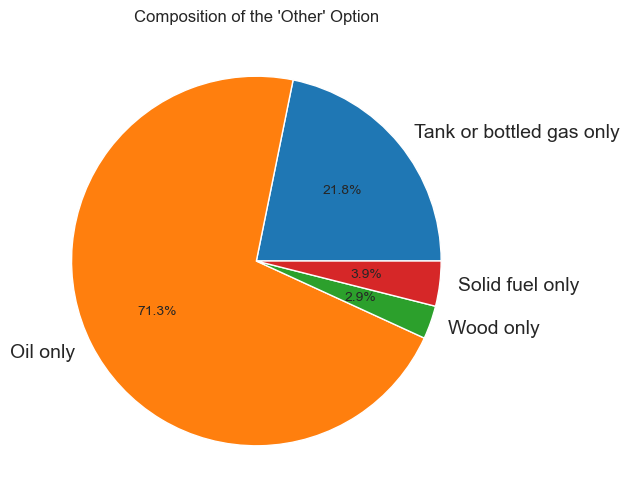

In [1735]:
plt.figure(figsize=[8,6])
plt.pie(heat_prop_eng_df_sub,labels = heat_prop_eng_df_sub.index, autopct='%.1f%%')
plt.title("Composition of the 'Other' Option")
plt.show()

In [1736]:
# heat_prop_eng_df_sub.to_csv(os.path.join(root_path, "Census", "2021Census England Fuel Composition for Other Option (Processed)"))

We need to infer the kWh data for space and water heating. This is done based on their corresponding main heating type
We also need to infer the kWh for other energy including cooking and lightening. We assume these are by pure electricity

In [1737]:
df_EHS_FP["heat_energy"] = (df_EHS_FP["spahcost"] + df_EHS_FP["wathcost"]) / df_EHS_FP["Mainfueltype"].map(Eng_fuel_uni_cost_dict_2019).astype("float")
df_EHS_FP["other_energy"] = (df_EHS_FP["litecost"] + df_EHS_FP["cookcost"]) / Eng_fuel_uni_cost_dict_2019["Electricity_pure"]
print(f"In England, the estimated heating energy occupies {weighted_mean(df_EHS_FP.heat_energy.values, df_EHS_FP['aagph1819']) / weighted_mean(df_EHS_FP.heat_energy.values + df_EHS_FP.other_energy.values, df_EHS_FP['aagph1819']) * 100}% of the total energy")

print(f"England mean household energy consumption for heating is {weighted_mean(df_EHS_FP.heat_energy.values, df_EHS_FP['aagph1819'])} kWh")
print(f"England mean household energy consumption for heating is {weighted_mean((df_EHS_FP['spahcost'] + df_EHS_FP['wathcost']+df_EHS_FP['litecost'] + df_EHS_FP['cookcost']).values, df_EHS_FP['aagph1819'])} £")

In England, the estimated heating energy occupies 81.33218254084905% of the total energy
England mean household energy consumption for heating is 15426.772090102555 kWh
England mean household energy consumption for heating is 1321.1836671237897 £


In [1738]:
# df_EHS_FP.to_csv(os.path.join(root_path, "df_EHS_FP_processed.csv"), index=False)

In [1739]:
## code for testing
# weighted_median(data = df_EHS_FP["heat_energy"].values, weights = df_EHS_FP["aagph1819"])
# weighted_median(data = df_EHS_FP["fuelexpn"].values, weights = df_EHS_FP["aagph1819"])
# weighted_median(data = df_EHS_FP["spahcost"].values + df_EHS_FP["wathcost"].values, weights = df_EHS_FP["aagph1819"])
# np.allclose(0, df_EHS_FP["spahcost"].values + df_EHS_FP["wathcost"].values + df_EHS_FP["litecost"] + df_EHS_FP["cookcost"] - df_EHS_FP["fuelexpn"].values)

In [1740]:
def fp_estimation_eng(df, fuel_uni_cost_dict, weight_key, region_analysis = False, consider_network_upgrade = False):
    # calculate energy cost per household
    df["energy_cost"] =  df["heat_energy"] * df["Mainfueltype"].map(fuel_uni_cost_dict).astype("float") + df["other_energy"] * fuel_uni_cost_dict["Electricity_pure"]
    if consider_upfrontcost:
        df["energy_cost"] = df["energy_cost"] + (df["Mainfueltype"] == "HP").values.astype("float") * HP_upfront_cost_dict[interest_rate]
        
    if consider_network_upgrade:
        df["energy_cost"] = df["energy_cost"] + df["gorehs"].str.lower().map(reg2networkcost_dict) / ave_num_years
    # estimate if it is fuel poor
    df["is_fp"] = df["incAHC"] * 0.1 <= df["energy_cost"]
    if not region_analysis:
        # estimate the rate
        fp_rate = np.sum(df["is_fp"].values * df[weight_key].values) / np.sum(df[weight_key].values)

        return fp_rate * 100

    res_dict = {}
    for region in df['gorehs'].unique():
        df_sub = df[df['gorehs'] == region]
        fp_rate = np.sum(df_sub["is_fp"].values * df_sub[weight_key].values) / np.sum(df_sub[weight_key].values)

        res_dict[region] = fp_rate * 100
    return res_dict

Eng_fp_res = fp_estimation_eng(df=df_EHS_FP, fuel_uni_cost_dict = Eng_fuel_uni_cost_dict, weight_key='aagph1819')
print(f"the England estimated fuel poverty rate is {Eng_fp_res}%")

the England estimated fuel poverty rate is 47.67715626793638%


If we replace all the nongas with HPs

In [1741]:
map_dict = {"gas": "gas",
            "electricity": "HP",
            "other": "HP"}

df_EHS_FP_replace = df_EHS_FP.copy()
df_EHS_FP_replace['Mainfueltype'] = df_EHS_FP_replace['Mainfueltype'].map(map_dict)

Eng_fp_res_HP = fp_estimation_eng(df=df_EHS_FP_replace, fuel_uni_cost_dict = Eng_fuel_uni_cost_dict, weight_key='aagph1819', consider_network_upgrade = True)
print(f"the England estimated fuel poverty rate AFTER HP replace is {Eng_fp_res_HP}%")

the England estimated fuel poverty rate AFTER HP replace is 46.88511006645282%


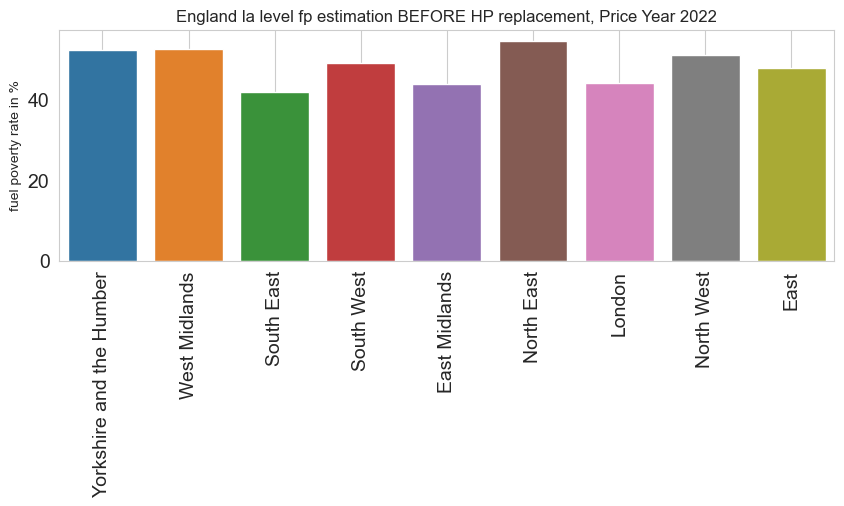

In [1742]:
### We can also analyse the 9 regions

Eng_reg_fp_estimation_dict = fp_estimation_eng(df_EHS_FP, Eng_fuel_uni_cost_dict, weight_key = "aagph1819", region_analysis = True)

keys = list(Eng_reg_fp_estimation_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [Eng_reg_fp_estimation_dict[k] for k in keys]
plt.figure(figsize=[10,3])
sns.barplot(x=keys, y=vals)
plt.xticks(rotation = 90)
plt.ylabel("fuel poverty rate in %")
plt.grid()
plt.title(f"England la level fp estimation BEFORE HP replacement, Price Year {price_year}")
vmin, vmax = 0, 1.05*max(vals)
plt.ylim([vmin, vmax])
plt.show()

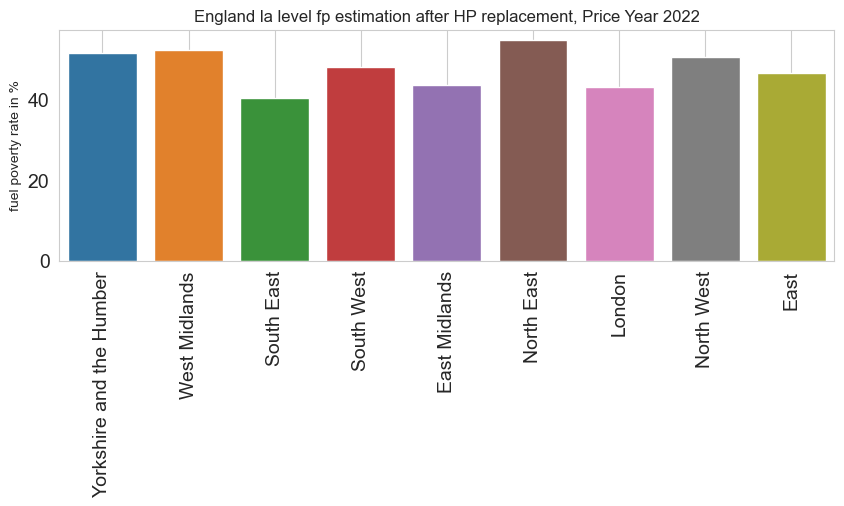

In [1743]:
### We can also analyse the 9 regions, after HP replacement

Eng_reg_fp_estimation_HP_dict = fp_estimation_eng(df_EHS_FP_replace, Eng_fuel_uni_cost_dict, weight_key = "aagph1819", region_analysis = True, consider_network_upgrade = True)

keys = list(Eng_reg_fp_estimation_HP_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [Eng_reg_fp_estimation_HP_dict[k] for k in keys]
plt.figure(figsize=[10,3])
sns.barplot(x=keys, y=vals)
plt.xticks(rotation = 90)
plt.ylabel("fuel poverty rate in %")
plt.grid()
plt.title(f"England la level fp estimation after HP replacement, Price Year {price_year}")
plt.ylim([vmin, vmax])
plt.show()

# Exploring the Geo Heatmap
The plots below have been included in Plotting.ipynb with better formats.
However the codes below also save data for plots with better formats.

In [1744]:
# load the raw dataset
uk_la_map_path = os.path.join(root_path, "Geo_data", "LAD_DEC_2022_UK_BFC.shp")
uk_la_map_df = gpd.read_file(uk_la_map_path)

eng_region_map_df = gpd.read_file(os.path.join(root_path, "Geo_data", "Regions_(December_2022)_EN_BFC.shp"))

## This file contains all the las in the whole UK, but we only need the ones in Scotland
Scot_la_code_list = ['S12000005','S12000006','S12000008','S12000010','S12000011','S12000013','S12000014','S12000017',
                     'S12000018','S12000019','S12000020','S12000021','S12000023','S12000026','S12000027','S12000028',
                     'S12000029','S12000030','S12000033','S12000034','S12000035','S12000036','S12000038','S12000039',
                     'S12000040','S12000041','S12000042','S12000045','S12000047','S12000048','S12000049','S12000050']

Scot_la_map_df = uk_la_map_df[uk_la_map_df["LAD22CD"].isin(Scot_la_code_list)]

map_df = pd.concat([Scot_la_map_df.rename(columns={"LAD22CD":"RegID", "LAD22NM":"RegName"}), eng_region_map_df.rename(columns={"RGN22CD":"RegID", "RGN22NM":"RegName"})]).pipe(gpd.GeoDataFrame)
map_df.head()

del uk_la_map_df
del Scot_la_map_df
del eng_region_map_df

In [1745]:
# this is to show the crs, which lets us know which projection it's using
map_df.crs
# map_df.to_file(os.path.join(os.getcwd(), "data_for_plot", "filtered_map.shp"))

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [1746]:
### save the household energy cost before and after HP replacement

df_cost = pd.concat([df_SHCS_3y[df_SHCS_3y["primFuel_biomass"] != "Mains gas"][["la", "energy_cost", "lafpWghtAHC"]].rename(columns={"la":"RegName", "lafpWghtAHC":'weight'}), df_EHS_FP[df_EHS_FP["Mainfueltype"] != "gas"][["gorehs", "energy_cost", "aagph1819"]].rename(columns={"gorehs":"RegName", 'aagph1819':'weight'})])
df_cost_HP = pd.concat([df_SHCS_3y_replace[df_SHCS_3y_replace["primFuel_biomass"] != "Mains gas"][["la", "energy_cost", "lafpWghtAHC"]].rename(columns={"la":"RegName", "lafpWghtAHC":'weight'}), df_EHS_FP_replace[df_EHS_FP_replace["Mainfueltype"] != "gas"][["gorehs", "energy_cost", 'aagph1819']].rename(columns={"gorehs":"RegName", 'aagph1819':'aagph1819'})])

if not consider_upfrontcost:
    df_cost.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost{price_year}_network_SPF{HP_SPF}.csv"), index=False)
    df_cost_HP.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP{price_year}_network_SPF{HP_SPF}.csv"), index=False)
else:
    if not gov_policy:
        df_cost.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost{price_year}_rate{interest_rate}_network_SPF{HP_SPF}.csv"), index=False)
        df_cost_HP.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP{price_year}_rate{interest_rate}_network_SPF{HP_SPF}.csv"), index=False)
    else:
        df_cost.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost{price_year}_rate{interest_rate}_gov_network_SPF{HP_SPF}.csv"), index=False)
        df_cost_HP.to_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP{price_year}_rate{interest_rate}_gov_network_SPF{HP_SPF}.csv"), index=False)

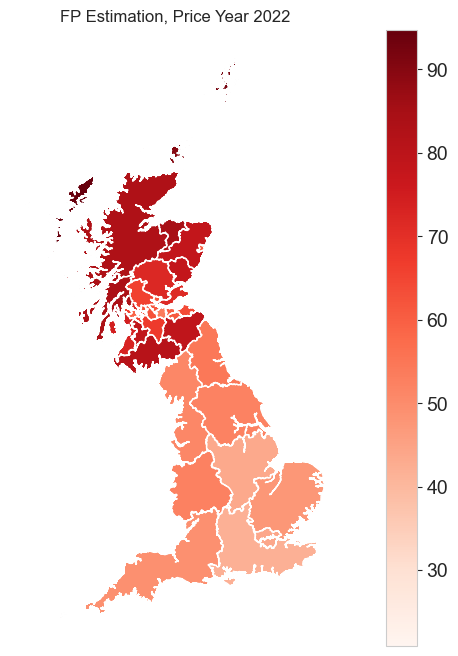

In [1747]:
### we need to merge the data we want to plot to the map df
All_fp_estimation_dict = {**Scot_la_fp_estimation_dict, **Eng_reg_fp_estimation_dict}

res = []
for regname in map_df["RegName"]:
    if regname in All_fp_estimation_dict:
        res.append(All_fp_estimation_dict[regname])
    ## we have so many elseif as their is slightly mismatch between LA names in different dataset.
    ## using la code is a smarter option, but due to the limited number of outliers, we use a brute force way
    elif regname == "City of Edinburgh":
        res.append(All_fp_estimation_dict["Edinburgh, City of"])
    elif regname == "Yorkshire and The Humber":
        res.append(All_fp_estimation_dict["Yorkshire and the Humber"])
    elif regname == "East of England":
        res.append(All_fp_estimation_dict["East"])
    elif regname == "Vale of Glamorgan":
        res.append(All_fp_estimation_dict["The Vale of Glamorgan"])
    else:
        print(regname)

res = np.array(res)
fp_res_df = pd.DataFrame(data=res.reshape([-1, 1]), columns=["fp_rate"])
map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_res_df.reset_index(drop=True))

fig, ax = plt.subplots(figsize = [12, 8])
cmap = "Reds"
vmin, vmax = 0.5*min(All_fp_estimation_dict.values()), max(All_fp_estimation_dict.values())
map_and_res_df.plot(column="fp_rate", cmap=cmap, ax = ax, legend=True, vmin =vmin, vmax = vmax)
ax.axis("off")
plt.title(f"FP Estimation, Price Year {price_year}")
plt.show()

del map_and_res_df

if not consider_upfrontcost:
    np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict{price_year}_network_SPF{HP_SPF}.npy"), All_fp_estimation_dict, allow_pickle=True)
else:
    if not gov_policy:
        np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict{price_year}_rate{interest_rate}_network_SPF{HP_SPF}.npy"), All_fp_estimation_dict, allow_pickle=True)
    else:
        np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict{price_year}_rate{interest_rate}_gov_network_SPF{HP_SPF}.npy"), All_fp_estimation_dict, allow_pickle=True)

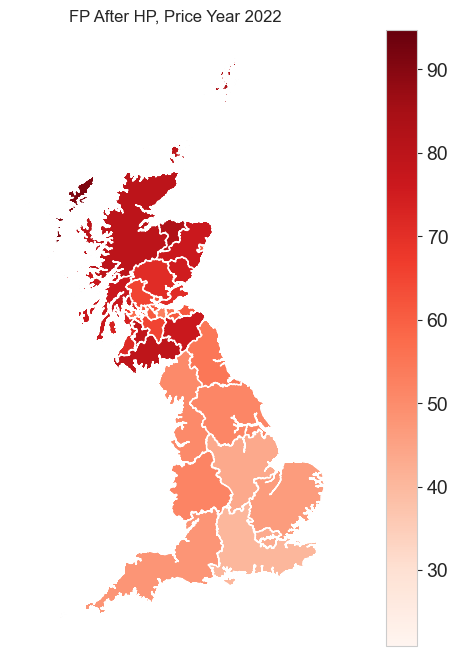

In [1748]:
All_fp_estimation_HP_dict = {**Scot_la_fp_estimation_HP_dict, **Eng_reg_fp_estimation_HP_dict}
res_HP = []
for regname in map_df["RegName"]:
    if regname in All_fp_estimation_HP_dict:
        res_HP.append(All_fp_estimation_HP_dict[regname])
    elif regname == "City of Edinburgh":
        res_HP.append(All_fp_estimation_HP_dict["Edinburgh, City of"])
    elif regname == "Yorkshire and The Humber":
        res_HP.append(All_fp_estimation_HP_dict["Yorkshire and the Humber"])
    elif regname == "East of England":
        res_HP.append(All_fp_estimation_HP_dict["East"])
    elif regname == "Vale of Glamorgan":
        res_HP.append(All_fp_estimation_HP_dict["The Vale of Glamorgan"])
    else:
        print(regname)

res_HP = np.array(res_HP)
fp_res_HP_df = pd.DataFrame(data=res_HP.reshape([-1, 1]), columns=["fp_rate_HP"])
map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_res_HP_df.reset_index(drop=True))

fig, ax = plt.subplots(figsize = [12, 8])
map_and_res_df.plot(column="fp_rate_HP", cmap=cmap, ax = ax, legend=True, vmin =vmin, vmax = vmax)
ax.axis("off")
plt.title(f"FP After HP, Price Year {price_year}")
plt.show()

del map_and_res_df

if not consider_upfrontcost:
    np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict{price_year}_network_SPF{HP_SPF}.npy"), All_fp_estimation_HP_dict, allow_pickle=True)
else:
    if not gov_policy:
        np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict{price_year}_rate{interest_rate}_network_SPF{HP_SPF}.npy"), All_fp_estimation_HP_dict, allow_pickle=True)
    else:
        np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict{price_year}_rate{interest_rate}_gov_network_SPF{HP_SPF}.npy"), All_fp_estimation_HP_dict, allow_pickle=True)

# Summarising the fp estimation for all the nations as well as the whole UK.
To get the fp for the whole UK, we need to know the number of households for all the three nations based on the 2021 Census for England and Wales, and 2011 Census res for Scotland (2022 data has not yet released)

In [1749]:
England_household_no = 23436085
Scotland_household_no = 2372777

tot_fp_res = (Scotland_household_no * Scot_fp_res + England_household_no * Eng_fp_res) / (Scotland_household_no + England_household_no)

tot_fp_res_HP = (Scotland_household_no * Scot_fp_res_HP + England_household_no * Eng_fp_res_HP) / (Scotland_household_no + England_household_no)

In [1750]:
fp_estimation_df = pd.DataFrame(data = np.array([[Scot_fp_res, Eng_fp_res, tot_fp_res],
                                                 [Scot_fp_res_HP, Eng_fp_res_HP, tot_fp_res_HP]]), columns= ["Scotland", "England", "total"], index=["Before HP", "After HP"])


print(f'FP estimation (%) based on price data in {price_year}')
fp_estimation_df

FP estimation (%) based on price data in 2022


,Scotland,England,total
Before HP,67.261758,47.677156,49.477696
After HP,65.162271,46.885110,48.565449


# More Analysis on Fuel Poverty

## Heatmap for FP Reduction

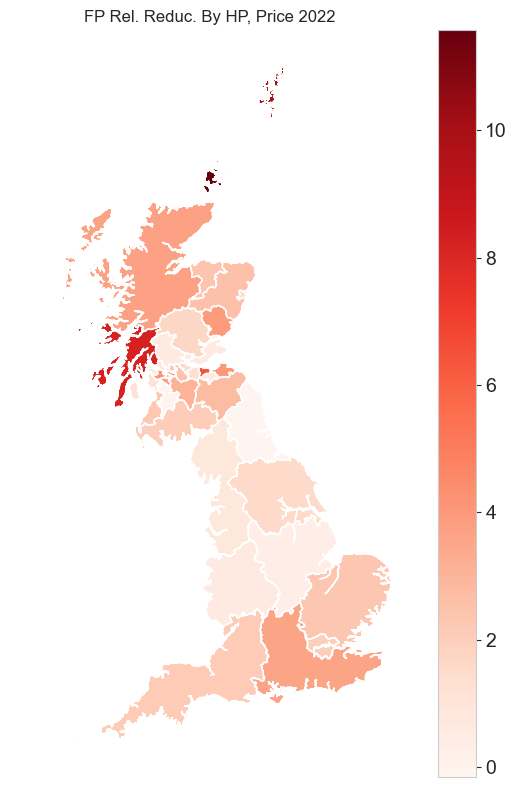

In [1751]:
# specify show absolute or relative difference
Absolute_diff = False

if Absolute_diff:
    fp_diff_df = pd.DataFrame(data = fp_res_df.values - fp_res_HP_df.values, columns = ["fp_diff"])
else:
    fp_diff_df = pd.DataFrame(data = 100*(fp_res_df.values - fp_res_HP_df.values) / fp_res_df.values, columns = ["fp_diff"])

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_diff_df.reset_index(drop=True))

vmin, vmax = 0.5*min(fp_diff_df.values), max(fp_diff_df.values)

fig, ax = plt.subplots(figsize = [6, 8])
map_and_res_df.plot(column="fp_diff", cmap=cmap, ax = ax, legend=True, vmin =vmin, vmax = vmax)
ax.axis("off")
plt.title(f"FP {'Abs.' if Absolute_diff else 'Rel.'} Reduc. By HP, Price {price_year}")

plt.tight_layout()
# plt.savefig(os.path.join(os.getcwd(), "figures", f"fp_diff_geomap_{price_year}_network_SPF{HP_SPF}.png"), dpi = 300)
plt.show()

del map_and_res_df
fp_diff_df["RegName"] = map_df["RegName"].copy()
fp_diff_df["RegCode"] = map_df["RegID"].copy()

In [1752]:
fp_diff_df

,fp_diff,RegName,RegCode
0,0.792698,Clackmannanshire,S12000005
1,2.075680,Dumfries and Galloway,S12000006
2,0.000000,East Ayrshire,S12000008
3,4.055667,East Lothian,S12000010
4,3.713985,East Renfrewshire,S12000011
5,3.659430,Na h-Eileanan Siar,S12000013
6,1.510433,Falkirk,S12000014
7,3.702746,Highland,S12000017
8,0.679978,Inverclyde,S12000018
9,0.581125,Midlothian,S12000019


## FP Reduction v.s. Non-gas Rate

The first step is of course find the nongas rate for all these regions

In [1753]:
# Scotland
Scot_la_name_list = df_SHCS_3y["la"].unique()
Scot_nongas_res = {}
for la in Scot_la_name_list:
    df_la = df_SHCS_3y[df_SHCS_3y["la"] == la]
    rate = df_la[df_la["primFuel_biomass"] != "Mains gas"]["lafpWghtAHC"].sum() / df_la["lafpWghtAHC"].sum()
    Scot_nongas_res[la] = rate


In [1754]:
# England
Eng_reg_name_list = df_EHS_FP["gorehs"].unique()
Eng_nongas_res = {}
for reg in Eng_reg_name_list:
    df_la = df_EHS_FP[df_EHS_FP["gorehs"] == reg]
    rate = df_la[df_la["Mainfueltype"] != "gas"]["aagph1819"].sum() / df_la["aagph1819"].sum()
    Eng_nongas_res[reg] = rate


In [1755]:
All_nongas_res_dict = {**Scot_nongas_res, **Eng_nongas_res}
np.save(os.path.join(os.getcwd(), "data_for_plot", f"All_nongas_res_dict_network_SPF{HP_SPF}.npy"), All_nongas_res_dict, allow_pickle=True)
All_nongas_res_dict

{'Midlothian': 0.09405203109321653,
 'South Lanarkshire': 0.1816040012528693,
 'Edinburgh, City of': 0.13105959928260677,
 'Fife': 0.09151724006710905,
 'Glasgow City': 0.1420200121505401,
 'East Lothian': 0.180827682290556,
 'Angus': 0.3043316375851151,
 'Dumfries and Galloway': 0.4509386946004329,
 'Aberdeen City': 0.12167273537411738,
 'East Dunbartonshire': 0.05233993239725465,
 'East Ayrshire': 0.061789893393952036,
 'Argyll and Bute': 0.5898109478205288,
 'Shetland Islands': 1.0,
 'Falkirk': 0.10879703321052134,
 'North Lanarkshire': 0.07935578239542539,
 'Aberdeenshire': 0.41191468055991104,
 'Moray': 0.31936194204070906,
 'Inverclyde': 0.13937205732636646,
 'Na h-Eileanan Siar': 0.9517926584531755,
 'South Ayrshire': 0.17601112576478006,
 'Stirling': 0.21026287280504713,
 'West Dunbartonshire': 0.08778223070751712,
 'Clackmannanshire': 0.0571296005144094,
 'Dundee City': 0.1887044400534129,
 'Renfrewshire': 0.05976664306525994,
 'Highland': 0.561461762717632,
 'Scottish Borders

In [1756]:
All_reg_name_list = fp_diff_df["RegName"].tolist()
All_nongas_res_list = []

for regname in All_reg_name_list:
    if regname in All_nongas_res_dict:
        All_nongas_res_list.append(All_nongas_res_dict[regname])
    elif regname == "City of Edinburgh":
        All_nongas_res_list.append(All_nongas_res_dict["Edinburgh, City of"])
    elif regname == "Yorkshire and The Humber":
        All_nongas_res_list.append(All_nongas_res_dict["Yorkshire and the Humber"])
    elif regname == "East of England":
        All_nongas_res_list.append(All_nongas_res_dict["East"])
    elif regname == "Vale of Glamorgan":
        All_nongas_res_list.append(All_nongas_res_dict["The Vale of Glamorgan"])
    else:
        print(regname)

FPvsNongas_df = fp_diff_df.copy()
FPvsNongas_df["nongas rate"] = All_nongas_res_list
FPvsNongas_df

,fp_diff,RegName,RegCode,nongas rate
0,0.792698,Clackmannanshire,S12000005,0.057130
1,2.075680,Dumfries and Galloway,S12000006,0.450939
2,0.000000,East Ayrshire,S12000008,0.061790
3,4.055667,East Lothian,S12000010,0.180828
4,3.713985,East Renfrewshire,S12000011,0.074960
5,3.659430,Na h-Eileanan Siar,S12000013,0.951793
6,1.510433,Falkirk,S12000014,0.108797
7,3.702746,Highland,S12000017,0.561462
8,0.679978,Inverclyde,S12000018,0.139372
9,0.581125,Midlothian,S12000019,0.094052


The pearson corr is 0.7388881773321461


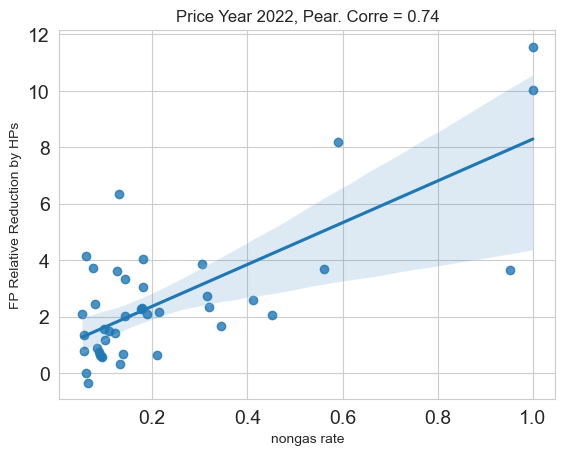

In [1757]:
sns.regplot(data = FPvsNongas_df, x="nongas rate", y="fp_diff")
corr = np.corrcoef(FPvsNongas_df["fp_diff"], FPvsNongas_df["nongas rate"])[0,1]
plt.title(f"Price Year {price_year}, Pear. Corre = {np.round(corr, 2)}")
plt.ylabel(f"FP {'Absolute' if Absolute_diff else 'Relative'} Reduction by HPs")
print(f"The pearson corr is {corr}")

In [1758]:
FPvsNongas_df.sort_values(by = "nongas rate")

,fp_diff,RegName,RegCode,nongas rate
27,2.111714,East Dunbartonshire,S12000045,0.052340
24,1.371650,West Lothian,S12000040,0.055550
0,0.792698,Clackmannanshire,S12000005,0.057130
22,4.166872,Renfrewshire,S12000038,0.059767
2,0.000000,East Ayrshire,S12000008,0.061790
32,-0.324324,North East,E12000001,0.064434
4,3.713985,East Renfrewshire,S12000011,0.074960
31,2.452423,North Lanarkshire,S12000050,0.079356
33,0.881642,North West,E12000002,0.083795
23,0.744974,West Dunbartonshire,S12000039,0.087782


# Extra, analyse the mean energy and no households for nongas and Elec for heating in Scotland and England

In [1759]:
Scot_la_aveheatenergy = {}
Scot_la_nongas_rate = {}
Scot_la_elec_rate = {}
for laname in df_SHCS_3y["la"].unique():
    subdf = df_SHCS_3y[df_SHCS_3y["la"] == laname]
    meanheat = weighted_mean(0.87*subdf['annkWh_fp3_BRE'].values, subdf['lafpWghtAHC'])
    nongas_rate = subdf[subdf["primFuel_biomass"] != "Mains gas"]['lafpWghtAHC'].sum() / subdf['lafpWghtAHC'].sum()
    elec_rate = subdf[subdf["primFuel_biomass"] == "Electricity"]['lafpWghtAHC'].sum() / subdf['lafpWghtAHC'].sum()
    if laname == "Edinburgh, City of":
        laname = "city of edinburgh"

    Scot_la_aveheatenergy[laname.lower()] = meanheat
    Scot_la_nongas_rate[laname.lower()] = nongas_rate
    Scot_la_elec_rate[laname.lower()] = elec_rate

Eng_reg_aveheatenergy = {}
Eng_reg_nongas_rate = {}
Eng_reg_elec_rate = {}
for regname in df_EHS_FP["gorehs"].unique():
    subdf = df_EHS_FP[df_EHS_FP["gorehs"] == regname]
    meanheat = weighted_mean(subdf.heat_energy.values, subdf['aagph1819'])
    nongas_rate = subdf[subdf["Mainfueltype"] != "gas"]['aagph1819'].sum() / subdf['aagph1819'].sum()
    elec_rate = subdf[subdf["Mainfueltype"] == "electricity"]['aagph1819'].sum() / subdf['aagph1819'].sum()
    if regname == "East":
        regname = "east of england"

    Eng_reg_aveheatenergy[regname.lower()] = meanheat
    Eng_reg_nongas_rate[regname.lower()] = nongas_rate
    Eng_reg_elec_rate[regname.lower()] = elec_rate

reg_aveheatenergy = {**Scot_la_aveheatenergy, **Eng_reg_aveheatenergy}
reg_nongas_rate = {**Scot_la_nongas_rate, **Eng_reg_nongas_rate}
reg_elec_rate = {**Scot_la_elec_rate, **Eng_reg_elec_rate}
import pickle
# ### save
# with open(os.path.join(root_path, "HeatingProfileandDemand", 'reg_aveheatenergy.pkl'), 'wb') as f:
#     pickle.dump(reg_aveheatenergy, f)
# with open(os.path.join(root_path, "HeatingProfileandDemand", 'reg_nongas_rate.pkl'), 'wb') as f:
#     pickle.dump(reg_nongas_rate, f)
# with open(os.path.join(root_path, "HeatingProfileandDemand", 'reg_elec_rate.pkl'), 'wb') as f:
#     pickle.dump(reg_elec_rate, f)

# Plots with Network Upgrade Cost (Abandoned. See Plotting.ipynb)

In [1760]:
network_root_path = os.path.join(root_path, "UKM_PrimarySubstation_Data")
upgrade_cost_df = pd.read_csv(os.path.join(network_root_path, "reg_upgrade_cost.csv"))

reg2totcost = {upgrade_cost_df.iloc[i]["RegCode"]:upgrade_cost_df.iloc[i]["Upgrade Cost (M£)"] for i in range(len(upgrade_cost_df))}
reg2avecost = {upgrade_cost_df.iloc[i]["RegCode"]:upgrade_cost_df.iloc[i]["Upgrade Cost (M£)"]/upgrade_cost_df.iloc[i]["Number of PS"] for i in range(len(upgrade_cost_df))}

In [1761]:
# totcost_df = pd.DataFrame(data = map_df["RegID"].map(reg2totcost).values, columns=["Tot Upgrade Cost"])
# map_and_res_df = map_df.join(totcost_df.reset_index(drop=True))
#
# vmin, vmax = 0.5*min(totcost_df.values), max(totcost_df.values)
#
# fig, ax = plt.subplots(figsize = [12, 8])
# map_and_res_df.plot(column="Tot Upgrade Cost", cmap=cmap, ax = ax, legend=True, vmin =vmin, vmax = vmax)
# ax.axis("off")
# plt.title(f"Total PS Upgrade Cost (M£) by Regions")
# plt.show()
#
# del map_and_res_df

In [1762]:
# avecost_df = pd.DataFrame(data = map_df["RegID"].map(reg2avecost).values, columns=["Ave Upgrade Cost"])
# map_and_res_df = map_df.join(avecost_df.reset_index(drop=True))
#
# vmin, vmax = 0.5*min(avecost_df.values), max(avecost_df.values)
#
# fig, ax = plt.subplots(figsize = [6, 8])
# map_and_res_df.plot(column="Ave Upgrade Cost", cmap=cmap, ax = ax, legend=True, vmin =vmin, vmax = vmax)
# ax.axis("off")
# plt.title(f"Ave. PS Upgrade Cost (M£)")
#
# plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_geomap.png"), dpi = 300)
# plt.show()
#
# del map_and_res_df

### Which Region has the Highest Upgrade Cost and FP Rate/Effect

In [1763]:
fp_diff_df["Ave Upgrade Cost (M£)"] = fp_diff_df["RegCode"].map(reg2avecost)
fp_diff_df

,fp_diff,RegName,RegCode,Ave Upgrade Cost (M£)
0,0.792698,Clackmannanshire,S12000005,0.000000
1,2.075680,Dumfries and Galloway,S12000006,0.163740
2,0.000000,East Ayrshire,S12000008,0.000000
3,4.055667,East Lothian,S12000010,0.000000
4,3.713985,East Renfrewshire,S12000011,0.000000
5,3.659430,Na h-Eileanan Siar,S12000013,0.581149
6,1.510433,Falkirk,S12000014,0.000000
7,3.702746,Highland,S12000017,0.133953
8,0.679978,Inverclyde,S12000018,0.000000
9,0.581125,Midlothian,S12000019,0.000000


In [1764]:
# log_scale = True
#
# fig, ax = plt.subplots(figsize=[20,15])
#
# plt.plot(fp_diff_df['fp_diff'], fp_diff_df['Ave Upgrade Cost (M£)'], "bo", markersize = 20)
#
# xmax = fp_diff_df["fp_diff"].max()
# xmin = fp_diff_df["fp_diff"].min()
#
# ymax = fp_diff_df["Ave Upgrade Cost (M£)"].max()
# ymin = fp_diff_df["Ave Upgrade Cost (M£)"].min()
#
# ## divide regions
# # plt.axvline((xmax + xmin)/2)
# # plt.axhline((ymax + ymin)/2)
#
# plt.title('Cost vs Benefits')
# # Set x-axis label
# plt.xlabel(f'Proportion (%) of Households Pulled out of FP by HPs, Price Year {price_year}')
# # Set y-axis label
# plt.ylabel('Ave PS Upgrade Cost (M£)')
# plt.grid()
#
# from adjustText import adjust_text
# # ax = plt.gca()
# a = pd.concat({'x': fp_diff_df["fp_diff"], 'y': fp_diff_df["Ave Upgrade Cost (M£)"], 'val': fp_diff_df["RegName"]}, axis=1)
#
# if log_scale:
#     ax.set_yscale('symlog', linthresh = 2e-2)
#     ax.set_xscale('log')
#     texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows()]
# else:
#     texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows()]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))
#
# corr = np.corrcoef(fp_diff_df["fp_diff"], fp_diff_df["Ave Upgrade Cost (M£)"])[0,1]
# print(f"The pearson corr is {corr}")

## Combine GHG Emission

In [1765]:
# GHG_reduction_rate_dict = np.load(os.path.join(root_path, "GHG_reduction_rate_dict.npy"), allow_pickle=True).item()
# GHG_reduction_rate_dict["City of Edinburgh"] = GHG_reduction_rate_dict.pop("Edinburgh, City of")
# GHG_reduction_rate_dict["Yorkshire and The Humber"] = GHG_reduction_rate_dict.pop("Yorkshire and the Humber")
# GHG_reduction_rate_dict["East of England"] = GHG_reduction_rate_dict.pop("East")
# fp_diff_df["GHG Reduc. Rate"] = fp_diff_df["RegName"].map(GHG_reduction_rate_dict)*100

In [1766]:
# sns.regplot(data = fp_diff_df, x="GHG Reduc. Rate", y="fp_diff")
# corr = np.corrcoef(fp_diff_df["GHG Reduc. Rate"], fp_diff_df["fp_diff"])[0,1]
# plt.title(f"Price Year {price_year}, Pear. Corre = {np.round(corr, 2)}")
# plt.ylabel(f"FP {'Absolute' if Absolute_diff else 'Relative'} Reduction by HPs")
# print(f"The pearson corr is {corr}")

### Electricity proportion in nongas heating vs GHG Reduction

In [1767]:
# # Scotland
# Scot_la_name_list = df_SHCS_3y["la"].unique()
# Scot_Enongas_res = {}
# for la in Scot_la_name_list:
#     df_la = df_SHCS_3y[df_SHCS_3y["la"] == la]
#     rate = df_la[df_la["primFuel_biomass"] == "Electricity"]["lafpWghtAHC"].sum() / df_la[df_la["primFuel_biomass"] != "Mains gas"]["lafpWghtAHC"].sum()
#     Scot_Enongas_res[la] = rate
#
# # England
# Eng_reg_name_list = df_EHS_FP["gorehs"].unique()
# Eng_Enongas_res = {}
# for reg in Eng_reg_name_list:
#     df_la = df_EHS_FP[df_EHS_FP["gorehs"] == reg]
#     rate = df_la[df_la["Mainfueltype"] == "electricity"]["aagph1819"].sum() / df_la[df_la["Mainfueltype"] != "gas"]["aagph1819"].sum()
#     Eng_Enongas_res[reg] = rate
#
# All_Enongas_res_dict = {**Scot_Enongas_res, **Eng_Enongas_res}
# All_nongas_res_dict = {**Scot_nongas_res, **Eng_nongas_res}
#
# All_reg_name_list = fp_diff_df["RegName"].tolist()
# All_Enongas_res_list = []
# All_nongas_res_list = []
#
# for regname in All_reg_name_list:
#     if regname in All_nongas_res_dict:
#         All_Enongas_res_list.append(All_Enongas_res_dict[regname])
#         All_nongas_res_list.append(All_nongas_res_dict[regname])
#     elif regname == "City of Edinburgh":
#         All_Enongas_res_list.append(All_Enongas_res_dict["Edinburgh, City of"])
#         All_nongas_res_list.append(All_nongas_res_dict["Edinburgh, City of"])
#     elif regname == "Yorkshire and The Humber":
#         All_Enongas_res_list.append(All_Enongas_res_dict["Yorkshire and the Humber"])
#         All_nongas_res_list.append(All_nongas_res_dict["Yorkshire and the Humber"])
#     elif regname == "East of England":
#         All_Enongas_res_list.append(All_Enongas_res_dict["East"])
#         All_nongas_res_list.append(All_nongas_res_dict["East"])
#     elif regname == "Vale of Glamorgan":
#         All_Enongas_res_list.append(All_Enongas_res_dict["The Vale of Glamorgan"])
#         All_nongas_res_list.append(All_nongas_res_dict["The Vale of Glamorgan"])
#     else:
#         print(regname)
#
# FPvsErate_df = fp_diff_df.copy()
# FPvsErate_df["E nongas rate"] = All_Enongas_res_list
# FPvsErate_df["nongas rate"] = All_nongas_res_list
#
# '''
# the function below is for plotting
# '''
# print(f"Price year {price_year}")
# plt.figure(figsize=[16,14])
#
# plt.subplot(221)
# sns.regplot(data = FPvsErate_df, x="nongas rate", y="fp_diff")
# corr = np.corrcoef(FPvsErate_df["fp_diff"], FPvsErate_df["nongas rate"])[0,1]
# plt.title(f"FPdff vs nongas rate")
# plt.ylabel(f"FP {'Absolute' if Absolute_diff else 'Relative'} Reduction by HPs")
# print(f"The pearson corr is {corr}")
#
# plt.subplot(222)
# sns.regplot(data = FPvsErate_df, x="E nongas rate", y="fp_diff")
# corr = np.corrcoef(FPvsErate_df["fp_diff"], FPvsErate_df["E nongas rate"])[0,1]
# plt.title(f"FPdff vs Enongas rate")
# plt.ylabel(f"FP {'Absolute' if Absolute_diff else 'Relative'} Reduction by HPs")
# print(f"The pearson corr is {corr}")
#
# plt.subplot(223)
# sns.regplot(data = FPvsErate_df, x="E nongas rate", y="nongas rate")
# corr = np.corrcoef(FPvsErate_df["nongas rate"], FPvsErate_df["E nongas rate"])[0,1]
# plt.title(f"nongas rate vs Enongas rate")
# plt.ylabel(f"nongas rate")
# print(f"The pearson corr is {corr}")
#
# plt.subplot(224)
# sns.regplot(data = FPvsErate_df, x="E nongas rate", y="GHG Reduc. Rate")
# corr = np.corrcoef(FPvsErate_df["E nongas rate"], FPvsErate_df["GHG Reduc. Rate"])[0,1]
# plt.title(f"GHG Reduction Rate vs E nongas rate")
# plt.ylabel(f"HG Reduction Rate")
# print(f"The pearson corr is {corr}")
#
# plt.tight_layout()

In [1768]:
# from scipy.stats import spearmanr, pearsonr, kendalltau
#
# data = FPvsErate_df[["fp_diff", "Ave Upgrade Cost (M£)", "GHG Reduc. Rate", "E nongas rate", "nongas rate"]]
# data.rename(columns={"Ave Upgrade Cost (M£)":"Ave Upg. Cost"}, inplace=True)
# def corrfunc(x, y, **kws):
#     r, _ = spearmanr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.1, .9), xycoords=ax.transAxes)
#
# # fig, ax = plt.subplots(figsize=[16,16])
# g = sns.PairGrid(data, diag_sharey=False)
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.map_lower(corrfunc)
# g.map_upper(corrfunc)